In [3]:
!pip install gymnasium==0.27.1 -q
!pip install gymnasium[box2d] -q
!pip install moviepy -q
!pip install -U kora -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 22.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 55.5 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py install for box2d-py ... done
  DEPRECATION: box2d-py was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. pip 23.1 will enforce this behaviour change. A possible replacement is to fix the wheel build issue reported above. Discussion can be found at https://github.com/pypa/pip/issues/8368
  

In [7]:
from google.colab import drive

drive.mount('/content/gdrive')

%cd SPLTOPICS
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/SPLTOPICS
CartPole	    CartPole_v1_t2.pkl	   LunarLander-v2_t1.pkl
CartPole_v1_t0.pkl  LunarLander		   LunarLander-v2_t2.pkl
CartPole_v1_t1.pkl  LunarLander-v2_t0.pkl


In [4]:
import random
import numpy as np
import torch.cuda

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)


def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'


def apply_reward_to_go(raw_reward):
    rtg_rewards = np.array([np.sum(raw_reward[i:]) for i in range(len(raw_reward))])
    rtg_rewards = (rtg_rewards - np.mean(rtg_rewards)) / (np.std(rtg_rewards) + np.finfo(np.float32).eps)
    return torch.tensor(rtg_rewards, dtype=torch.float32, device=get_device())


def apply_discount(raw_reward, gamma=0.99):
    discounted_rtg_reward = np.array([np.sum([gamma ** j * raw_reward[i+j] for j in range(len(raw_reward)-i)]) for i in range(len(raw_reward))])
    discounted_rtg_reward = (discounted_rtg_reward - np.mean(discounted_rtg_reward)) / (np.std(discounted_rtg_reward) + np.finfo(np.float32).eps)
    return torch.tensor(discounted_rtg_reward, dtype=torch.float32, device=get_device())


# Util function to apply reward-return (cumulative reward) on a list of instant-reward (from eq 6)
def apply_return(raw_reward):
    # Compute r_reward (as a list) from raw_reward
    r_reward = [np.sum(raw_reward) for _ in raw_reward]
    return torch.tensor(r_reward, dtype=torch.float32, device=get_device())

In [5]:
import pickle
import gymnasium as gym
import torch
from gymnasium.utils.save_video import save_video
from torch import nn
from torch.optim import Adam
from torch.distributions import Categorical


class PGTrainer:
    def __init__(self, params):
        self.params = params
        self.env = gym.make(self.params['env_name'])
        self.agent = Agent(env=self.env, params=self.params)
        self.actor_policy = PGPolicy(input_size=self.env.observation_space.shape[0], output_size=self.env.action_space.n, hidden_dim=self.params['hidden_dim']).to(get_device())
        self.optimizer = Adam(params=self.actor_policy.parameters(), lr=self.params['lr'])

    def run_training_loop(self):
        list_ro_reward = list()

        for ro_idx in range(self.params['n_rollout']):
            trajectory = self.agent.collect_trajectory(policy=self.actor_policy)
            loss = self.estimate_loss_function(trajectory)
            self.update_policy(loss)
            # Calculate avg reward for this rollout
            total_reward = sum([sum(traj_rewards) for traj_rewards in trajectory['reward']])
            ntr = self.params['n_trajectory_per_rollout']
            avg_ro_reward = total_reward / ntr
            print(f'End of rollout {ro_idx}: Average trajectory reward is {avg_ro_reward: 0.2f}')
            # Append average rollout reward into a list
            list_ro_reward.append(avg_ro_reward)
        # Save avg-rewards as pickle files
        pkl_file_name = self.params['exp_name'] + '.pkl'
        with open(pkl_file_name, 'wb') as f:
            pickle.dump(list_ro_reward, f)
        # Save a video of the trained agent playing
        self.generate_video()
        # Close environment
        self.env.close()

    def estimate_loss_function(self, trajectory):
          loss_functions = {
            (True, True): lambda r: apply_discount(apply_reward_to_go(r)),
            (True, False): apply_reward_to_go,
            (False, True): apply_discount,
            (False, False): apply_return,
         }

          loss = []
          for t_idx in range(self.params['n_trajectory_per_rollout']):
        # Get the rewards for the current trajectory
              reward = torch.tensor(trajectory['reward'][t_idx], dtype=torch.float32)

        # Get the log-probs for the current trajectory
              log_prob = trajectory['log_prob'][t_idx]

        # Compute the loss based on the flags using switch
              loss_fn = loss_functions[(self.params['reward_to_go'], self.params['reward_discount'])]
              loss.append(-1 * (loss_fn(reward.tolist()) * log_prob).mean())

          loss = torch.stack(loss).mean()
          return loss




    def update_policy(self, loss):
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

    def generate_video(self, max_frame=1000):
        self.env = gym.make(self.params['env_name'], render_mode='rgb_array_list')
        obs, _ = self.env.reset()
        for _ in range(max_frame):
            action_idx, log_prob = self.actor_policy(torch.tensor(obs, dtype=torch.float32, device=get_device()))
            obs, reward, terminated, truncated, info = self.env.step(self.agent.action_space[action_idx.item()])
            if terminated or truncated:
                break
        save_video(frames=self.env.render(), video_folder=self.params['env_name'][:-3], fps=self.env.metadata['render_fps'], step_starting_index=0, episode_index=0)

class PGPolicy(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim):
        super(PGPolicy, self).__init__()
        self.policy_net = nn.Sequential(
        nn.Linear(input_size, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, output_size),
        nn.Softmax(dim=-1)
        )


    def forward(self, obs):
        # Forward pass of policy net
        policy_dist = Categorical(self.policy_net(obs))
        action_index = policy_dist.sample()
        log_prob = policy_dist.log_prob(action_index)
        return action_index, log_prob


class Agent:
    def __init__(self, env, params=None):
        self.env = env
        self.params = params
        self.action_space = [action for action in range(self.env.action_space.n)]

    def collect_trajectory(self, policy):
        obs, _ = self.env.reset(seed=self.params['rng_seed'])
        rollout_buffer = list()
        for _ in range(self.params['n_trajectory_per_rollout']):
            trajectory_buffer = {'log_prob': list(), 'reward': list()}
            while True:
                # Convert observation to tensor
                obs_tensor = torch.tensor(obs, dtype=torch.float32)
                action_idx, log_prob = policy.forward(obs_tensor)

# Execute chosen action in the environment
                action = self.action_space[action_idx.item()]
                obs, reward, terminated, truncated, info = self.env.step(action)


                # Save log-prob and reward into the buffer
                trajectory_buffer['log_prob'].append(log_prob)
                trajectory_buffer['reward'].append(reward)
                # Check for termination criteria
                if terminated or truncated:
                    obs, _ = self.env.reset(seed=self.params['rng_seed'])
                    rollout_buffer.append(trajectory_buffer)
                    break
        rollout_buffer = self.serialize_trajectory(rollout_buffer)
        return rollout_buffer

    # Converts a list-of-dictionary into dictionary-of-list
    @staticmethod
    def serialize_trajectory(rollout_buffer):
        serialized_buffer = {'log_prob': list(), 'reward': list()}
        for trajectory_buffer in rollout_buffer:
            serialized_buffer['log_prob'].append(torch.stack(trajectory_buffer['log_prob']))
            serialized_buffer['reward'].append(trajectory_buffer['reward'])
        return serialized_buffer

In [6]:
# Define four sets of parameters
params_list = [
    {
        'env_name': 'CartPole-v1',
        'rng_seed': 6369,
        'reward_to_go': False,
        'reward_discount': False,
        'n_rollout': 100,
        'n_trajectory_per_rollout': 10,
        'hidden_dim': 64,
        'lr': 3e-3,
        'exp_name': 'CartPole_v1_t0'
    },
    {
        'env_name': 'CartPole-v1',
        'rng_seed': 6369,
        'reward_to_go': True,
        'reward_discount': False,
        'n_rollout': 100,
        'n_trajectory_per_rollout': 10,
        'hidden_dim': 64,
        'lr': 3e-3,
        'exp_name': 'CartPole_v1_t1'
    },
    {
        'env_name': 'CartPole-v1',
        'rng_seed': 6369,
        'reward_to_go': False,
        'reward_discount': True,
        'n_rollout': 100,
        'n_trajectory_per_rollout': 10,
        'hidden_dim': 64,
        'lr': 3e-3,
        'exp_name': 'CartPole_v1_t2'
    }
]

# Train agent with each set of parameters
for params in params_list:
    # Seed RNGs
    seed_everything(params['rng_seed'])

    # Train agent
    trainer = PGTrainer(params)
    trainer.run_training_loop()

End of rollout 0: Average trajectory reward is  21.40
End of rollout 1: Average trajectory reward is  21.10
End of rollout 2: Average trajectory reward is  24.90
End of rollout 3: Average trajectory reward is  18.40
End of rollout 4: Average trajectory reward is  18.10
End of rollout 5: Average trajectory reward is  20.60
End of rollout 6: Average trajectory reward is  22.80
End of rollout 7: Average trajectory reward is  21.50
End of rollout 8: Average trajectory reward is  20.00
End of rollout 9: Average trajectory reward is  15.60
End of rollout 10: Average trajectory reward is  17.10
End of rollout 11: Average trajectory reward is  17.30
End of rollout 12: Average trajectory reward is  18.70
End of rollout 13: Average trajectory reward is  21.00
End of rollout 14: Average trajectory reward is  21.00
End of rollout 15: Average trajectory reward is  17.70
End of rollout 16: Average trajectory reward is  17.70
End of rollout 17: Average trajectory reward is  29.00
End of rollout 18: A

Moviepy - Done !
Moviepy - video ready /content/CartPole/rl-video-episode-0.mp4
End of rollout 0: Average trajectory reward is  21.40
End of rollout 1: Average trajectory reward is  21.40
End of rollout 2: Average trajectory reward is  23.50
End of rollout 3: Average trajectory reward is  18.50
End of rollout 4: Average trajectory reward is  17.90
End of rollout 5: Average trajectory reward is  18.00
End of rollout 6: Average trajectory reward is  20.40
End of rollout 7: Average trajectory reward is  15.40
End of rollout 8: Average trajectory reward is  16.50
End of rollout 9: Average trajectory reward is  20.30
End of rollout 10: Average trajectory reward is  19.60
End of rollout 11: Average trajectory reward is  23.20
End of rollout 12: Average trajectory reward is  16.90
End of rollout 13: Average trajectory reward is  20.10
End of rollout 14: Average trajectory reward is  25.20
End of rollout 15: Average trajectory reward is  19.30
End of rollout 16: Average trajectory reward is  2

Moviepy - Done !
Moviepy - video ready /content/CartPole/rl-video-episode-0.mp4
End of rollout 0: Average trajectory reward is  21.40
End of rollout 1: Average trajectory reward is  21.40
End of rollout 2: Average trajectory reward is  23.50
End of rollout 3: Average trajectory reward is  18.00
End of rollout 4: Average trajectory reward is  19.30
End of rollout 5: Average trajectory reward is  17.40
End of rollout 6: Average trajectory reward is  23.20
End of rollout 7: Average trajectory reward is  17.50
End of rollout 8: Average trajectory reward is  15.90
End of rollout 9: Average trajectory reward is  19.90
End of rollout 10: Average trajectory reward is  29.80
End of rollout 11: Average trajectory reward is  18.70
End of rollout 12: Average trajectory reward is  16.50
End of rollout 13: Average trajectory reward is  26.00
End of rollout 14: Average trajectory reward is  19.00
End of rollout 15: Average trajectory reward is  20.10
End of rollout 16: Average trajectory reward is  2

Moviepy - Done !
Moviepy - video ready /content/CartPole/rl-video-episode-0.mp4


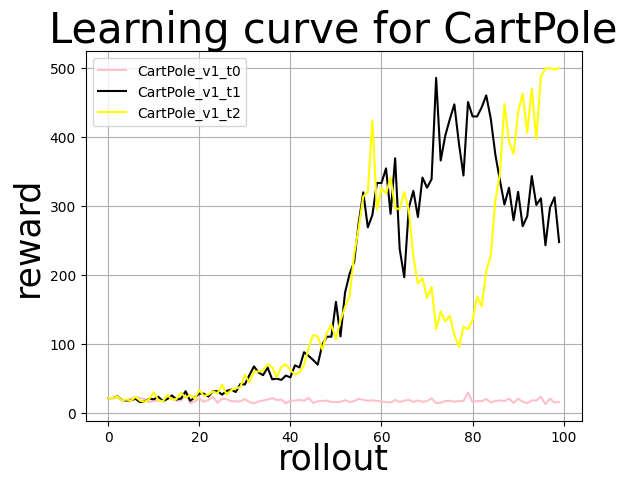

In [7]:
import argparse
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# Load rewards data for each experiment
exp_names = ['CartPole_v1_t0', 'CartPole_v1_t1', 'CartPole_v1_t2']
colors = ['pink', 'black', 'yellow']
exp_rewards = []
for name in exp_names:
    with open(name+'.pkl', 'rb') as f:
        exp_rewards.append(pickle.load(f))

# Plot the data
for i in range(len(exp_rewards)):
    sns.lineplot(data=exp_rewards[i], color=colors[i], label=exp_names[i])
plt.xlabel('rollout', fontsize=25, labelpad=-2)
plt.ylabel('reward', fontsize=25)
plt.title('Learning curve for CartPole', fontsize=30)
plt.legend()
plt.grid()
plt.show()

In [8]:
params_list = [
    {
        'env_name': 'LunarLander-v2',
        'rng_seed': 6369,
        'reward_to_go': False,
        'reward_discount': True,
        'n_rollout': 125,
        'n_trajectory_per_rollout': 5,
        'hidden_dim': 128,
        'lr': 3e-3,
        'exp_name': 'LunarLander-v2_t0'
    },
     {
        'env_name': 'LunarLander-v2',
        'rng_seed': 6369,
        'reward_to_go': False,
        'reward_discount': True,
        'n_rollout': 125,
        'n_trajectory_per_rollout': 20,
        'hidden_dim': 128,
        'lr': 3e-3,
        'exp_name': 'LunarLander-v2_t1'
    },
      {
        'env_name': 'LunarLander-v2',
        'rng_seed': 6369,
        'reward_to_go': False,
        'reward_discount': True,
        'n_rollout': 125,
        'n_trajectory_per_rollout': 60,
        'hidden_dim': 128,
        'lr': 3e-3,
        'exp_name': 'LunarLander-v2_t2'
    },
]

# Train agent with each set of parameters
for params in params_list:
    # Seed RNGs
    seed_everything(params['rng_seed'])

    # Train agent
    trainer = PGTrainer(params)
    trainer.run_training_loop()



End of rollout 0: Average trajectory reward is -321.95
End of rollout 1: Average trajectory reward is -172.70
End of rollout 2: Average trajectory reward is -207.05
End of rollout 3: Average trajectory reward is -173.51
End of rollout 4: Average trajectory reward is -146.09
End of rollout 5: Average trajectory reward is -262.84
End of rollout 6: Average trajectory reward is -301.92
End of rollout 7: Average trajectory reward is -335.43
End of rollout 8: Average trajectory reward is -319.98
End of rollout 9: Average trajectory reward is -321.26
End of rollout 10: Average trajectory reward is -248.44
End of rollout 11: Average trajectory reward is -328.46
End of rollout 12: Average trajectory reward is -292.44
End of rollout 13: Average trajectory reward is -328.40
End of rollout 14: Average trajectory reward is -376.50
End of rollout 15: Average trajectory reward is -285.01
End of rollout 16: Average trajectory reward is -289.34
End of rollout 17: Average trajectory reward is -302.57
En

Moviepy - Done !
Moviepy - video ready /content/LunarLander/rl-video-episode-0.mp4
End of rollout 0: Average trajectory reward is -300.03
End of rollout 1: Average trajectory reward is -238.19
End of rollout 2: Average trajectory reward is -186.27
End of rollout 3: Average trajectory reward is -161.50
End of rollout 4: Average trajectory reward is -196.66
End of rollout 5: Average trajectory reward is -222.58
End of rollout 6: Average trajectory reward is -233.90
End of rollout 7: Average trajectory reward is -240.06
End of rollout 8: Average trajectory reward is -249.77
End of rollout 9: Average trajectory reward is -243.30
End of rollout 10: Average trajectory reward is -289.33
End of rollout 11: Average trajectory reward is -301.11
End of rollout 12: Average trajectory reward is -293.23
End of rollout 13: Average trajectory reward is -324.43
End of rollout 14: Average trajectory reward is -317.91
End of rollout 15: Average trajectory reward is -328.50
End of rollout 16: Average traj

Moviepy - Done !
Moviepy - video ready /content/LunarLander/rl-video-episode-0.mp4
End of rollout 0: Average trajectory reward is -309.38
End of rollout 1: Average trajectory reward is -224.00
End of rollout 2: Average trajectory reward is -167.30
End of rollout 3: Average trajectory reward is -174.64
End of rollout 4: Average trajectory reward is -193.96
End of rollout 5: Average trajectory reward is -223.86
End of rollout 6: Average trajectory reward is -260.42
End of rollout 7: Average trajectory reward is -284.48
End of rollout 8: Average trajectory reward is -259.05
End of rollout 9: Average trajectory reward is -268.68
End of rollout 10: Average trajectory reward is -277.15
End of rollout 11: Average trajectory reward is -276.81
End of rollout 12: Average trajectory reward is -297.28
End of rollout 13: Average trajectory reward is -260.94
End of rollout 14: Average trajectory reward is -287.77
End of rollout 15: Average trajectory reward is -267.88
End of rollout 16: Average traj

Moviepy - Done !
Moviepy - video ready /content/LunarLander/rl-video-episode-0.mp4


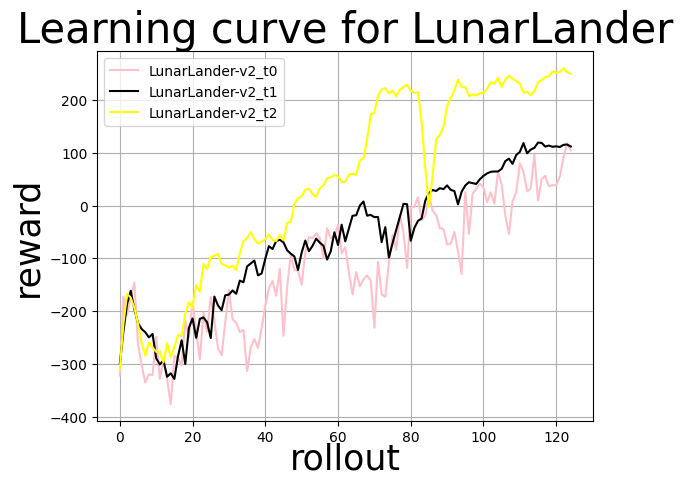

In [9]:
import argparse
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# Load rewards data for each experiment
exp_names = ['LunarLander-v2_t0', 'LunarLander-v2_t1', 'LunarLander-v2_t2']
colors = ['pink', 'black', 'yellow']
exp_rewards = []
for name in exp_names:
    with open(name+'.pkl', 'rb') as f:
        exp_rewards.append(pickle.load(f))

# Plot the data
for i in range(len(exp_rewards)):
    sns.lineplot(data=exp_rewards[i], color=colors[i], label=exp_names[i])
plt.xlabel('rollout', fontsize=25, labelpad=-2)
plt.ylabel('reward', fontsize=25)
plt.title('Learning curve for LunarLander', fontsize=30)
plt.legend()
plt.grid()
plt.show()

# STUDENT NAME: Naveyah Injam
# STUDENT ID: 1002029985